# Sales Prediction

Using machine learning to help organization prepare to handle dynamic market demand. Organization may infer the prediction to establish rule, plan, or strategy to further strengthen market position.

## Library Import and Configuration

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

from util.dbconn import DbConn

In [2]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': '10.128.0.2',
    'port': '8084',
    'dbname': 'postgres'
}

In [3]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

## Data Overview

In [4]:
sql = """SELECT 
	dd."year",
	dd."month",
	dd.week_num_in_year,
	dd."date",
	count(DISTINCT fo.order_legacy_id) as count_order
FROM 
	warehouse.fact_order fo
LEFT JOIN warehouse.date_dim dd ON
	fo.order_date = dd.date_id
GROUP BY 1,2,3,4;
"""

In [5]:
df = pd.read_sql(sql=sql, con=postgres_conn)

display(df.info())
display(df.describe())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   year              634 non-null    int64
 1   month             634 non-null    int64
 2   week_num_in_year  634 non-null    int64
 3   date              634 non-null    int64
 4   count_order       634 non-null    int64
dtypes: int64(5)
memory usage: 24.9 KB


None

,year,month,week_num_in_year,date,count_order
count,634.000000,634.000000,634.000000,634.000000,634.000000
mean,2017.383281,5.938486,24.501577,15.597792,156.847003
std,0.533051,3.214452,14.111411,8.768610,94.224817
min,2016.000000,1.000000,1.000000,1.000000,1.000000
25%,2017.000000,3.000000,13.000000,8.000000,96.000000
50%,2017.000000,6.000000,24.000000,15.500000,148.000000
75%,2018.000000,8.000000,35.000000,23.000000,215.750000
max,2018.000000,12.000000,53.000000,31.000000,1176.000000


,year,month,week_num_in_year,date,count_order
0,2016,9,36,4,1
1,2016,9,37,5,1
2,2016,9,38,13,1
3,2016,9,38,15,1
4,2016,10,40,2,1


### Check Null Values

In [6]:
df.isnull().sum()

year                0
month               0
week_num_in_year    0
date                0
count_order         0
dtype: int64

## Exploratory Data Analysis

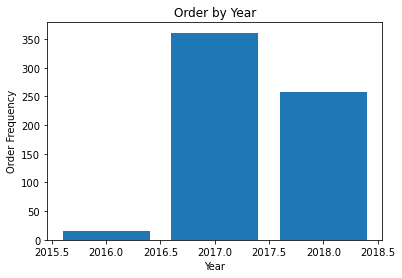

,year,count_order
0,2016,15
1,2017,361
2,2018,258


In [7]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'count_order']].groupby('year', as_index=False).count()

ax.bar(_df_temp['year'], _df_temp['count_order'])
ax.set_title('Order by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

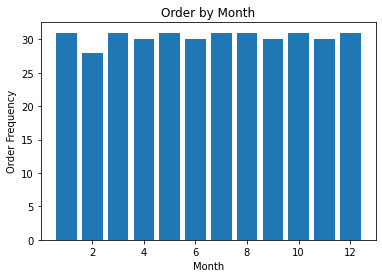

,year,month,count_order
0,2016,9,4
1,2016,10,10
2,2016,12,1
3,2017,1,27
4,2017,2,28
5,2017,3,31
6,2017,4,30
7,2017,5,31
8,2017,6,30
9,2017,7,31


In [8]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'month', 'count_order']] \
            .groupby(by=['year', 'month'], as_index=False) \
            .count()

ax.bar(_df_temp['month'], _df_temp['count_order'])
ax.set_title('Order by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

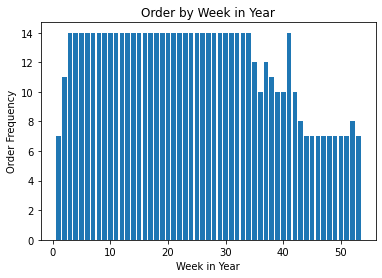

,week_num_in_year,count_order
0,1,7
1,2,11
2,3,14
3,4,14
4,5,14
5,6,14
6,7,14
7,8,14
8,9,14
9,10,14


In [9]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['week_num_in_year', 'count_order']] \
            .groupby(by='week_num_in_year', as_index=False) \
            .count()

ax.bar(_df_temp['week_num_in_year'], _df_temp['count_order'])
ax.set_title('Order by Week in Year')
ax.set_xlabel('Week in Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

In [10]:
model_df = df.copy()

## Data Preprocessing

In [11]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm='l2')

## Naive Model

In [12]:
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error

In [13]:
y = model_df.loc[:, 'count_order']
# Set to predict the mean
y_pred = [y.mean() for i in range(0, len(y))]

mse = mean_squared_error(y, y_pred)
print(mse)

8864.3125541104


## MLP Regressor

In [14]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline

In [15]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [16]:
# hidden_layer_sizes = [(100,), (100,30), (100, 30, 10)]
# activations = ['identity', 'logistic', 'tanh', 'relu']
# solvers = ['lbfgs', 'sgd', 'adam']
# learning_rate_sgd = ['constant', 'invscaling', 'adaptive']
# learning_rate_inits = [0.001, 0.003, 0.005, 0.01, 0.03, 0.1]
# tol = [0.0001, 0.001, 0.005, 0.01]

# def evaluate_mlpr_ht(X, mlpr):
#     tscv = TimeSeriesSplit()
#     errors = []
    
#     normalizer = Normalizer(norm='l2')
#     model = make_pipeline(normalizer, mlpr)

#     for train_index, test_index in tscv.split(X):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         mse = mean_squared_error(y_test, y_pred)
#         errors.append(mse)

#     return sum(errors)/len(errors)

# results = []

# for hl in hidden_layer_sizes:
#     mlpr = MLPRegressor(hidden_layer_sizes=hl, max_iter=1000)
#     error = evaluate_mlpr_ht(X, mlpr)
#     results.append({
#         'hidden_layer_size': hl,
#         'error': error
#     })

# for act in activations:
#     mlpr = MLPRegressor(activation=act, max_iter=1000)
#     error = evaluate_mlpr_ht(X, mlpr)
#     results.append({
#         'activation': act,
#         'error': error
#     })

# for slv in solvers:
#     mlpr = MLPRegressor(solver=slv, max_iter=1000)
#     error = evaluate_mlpr_ht(X, mlpr)
#     results.append({
#         'solver': slv,
#         'error': error
#     })

# for lr in learning_rate_sgd:
#     for lri in learning_rate_inits:
#         mlpr = MLPRegressor(learning_rate=lr,
#                           learning_rate_init=lri,
#                           solver='sgd',
#                           max_iter=1000)
#         error = evaluate_mlpr_ht(X, mlpr)
#         results.append({
#             'learning_rate': lr,
#             'learning_rate_init': lri,
#             'error': error
#         })

# for t in tol:
#     mlpr = MLPRegressor(tol=t, max_iter=1000)
#     error = evaluate_mlpr_ht(X, mlpr)
#     results.append({
#         'tol': t,
#         'error': error
#     })

# print(json.dumps(results, indent=4))

In [17]:
tscv = TimeSeriesSplit()

errors = []

mlpr = MLPRegressor()
model = make_pipeline(normalizer, mlpr)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    errors.append(mse)
    
print(sum(errors)/len(errors))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


27787.295533729397


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [18]:
## DO NOT DELETE
# mlpr = MLPRegressor(
#             hidden_layer_sizes=(100,30),
#             activation='relu',
#             solver='lbfgs',
#             learning_rate='constant',
#             learning_rate_init=0.001,
#             max_iter=1000)

### Default Parameter

In [19]:
def evaluate_mlpr(y_actual, y_pred):
    med_ae = median_absolute_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mean_squared_error(y_actual, y_pred, squared=False)
    
    return {
        'Median Absolute Error': med_ae,
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
    }

In [20]:
tscv = TimeSeriesSplit()

errors = []

mlpr = MLPRegressor()
model = make_pipeline(normalizer, mlpr)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    errors.append(evaluate_mlpr(y_test, y_pred))
    
print(json.dumps(errors, indent=4))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[
    {
        "Median Absolute Error": 104.1814634514001,
        "Mean Absolute Error": 103.15420174134582,
        "Mean Squared Error": 11553.39888812055,
        "Root Mean Squared Error": 107.48673819648891
    },
    {
        "Median Absolute Error": 114.72543903899235,
        "Mean Absolute Error": 113.78901011725593,
        "Mean Squared Error": 13706.99569601009,
        "Root Mean Squared Error": 117.07687942548729
    },
    {
        "Median Absolute Error": 189.82566775282243,
        "Mean Absolute Error": 200.80428550125683,
        "Mean Squared Error": 53739.71056061379,
        "Root Mean Squared Error": 231.8182705496135
    },
    {
        "Median Absolute Error": 178.71454230893877,
        "Mean Absolute Error": 174.32565207797128,
        "Mean Squared Error": 33940.887116153004,
        "Root Mean Squared Error": 184.23052710165328
    },
    {
        "Median Absolute Error": 122.57270780432046,
        "Mean Absolute Error": 130.03756705771556,
        "

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Final Model

In [21]:
tscv = TimeSeriesSplit()

errors = []

mlpr = MLPRegressor(max_iter=1000, activation='identity',
                   solver='sgd', learning_rate='constant',
                   tol=0.005)
model = make_pipeline(normalizer, mlpr)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    errors.append(evaluate_mlpr(y_test, y_pred))
    
print(json.dumps(errors, indent=4))

[
    {
        "Median Absolute Error": 51.688594701446775,
        "Mean Absolute Error": 51.57743029370292,
        "Mean Squared Error": 3480.956428564425,
        "Root Mean Squared Error": 58.9996307493905
    },
    {
        "Median Absolute Error": 56.13217712935773,
        "Mean Absolute Error": 55.19710621896661,
        "Mean Squared Error": 3805.8220299322807,
        "Root Mean Squared Error": 61.69134485430092
    },
    {
        "Median Absolute Error": 111.69993417707192,
        "Mean Absolute Error": 125.19181109178413,
        "Mean Squared Error": 28482.710285887195,
        "Root Mean Squared Error": 168.76821467885236
    },
    {
        "Median Absolute Error": 87.44600232775647,
        "Mean Absolute Error": 87.4673514058917,
        "Mean Squared Error": 10444.110860613337,
        "Root Mean Squared Error": 102.19643271960787
    },
    {
        "Median Absolute Error": 88.30911590392319,
        "Mean Absolute Error": 88.59764260099607,
        "Mean Sq

## Support Vector Regression

In [22]:
from sklearn.svm import LinearSVR

In [23]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Default Parameter

In [24]:
def _tscv(X, estimator):
    tscv = TimeSeriesSplit()

    errors = []
    
    model = make_pipeline(normalizer, estimator)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        errors.append(evaluate_mlpr(y_test, y_pred))

    print(json.dumps(errors[-1], indent=4))

In [25]:
svr = LinearSVR()

_tscv(X, svr)

{
    "Median Absolute Error": 113.00107252665174,
    "Mean Absolute Error": 99.51471372721342,
    "Mean Squared Error": 12769.841503462432,
    "Root Mean Squared Error": 113.00372340530392
}


### Final Model

In [26]:
final_svr = LinearSVR(tol=1e-4, max_iter=100000)

_tscv(X, final_svr)

{
    "Median Absolute Error": 112.99726078020024,
    "Mean Absolute Error": 99.51296247811756,
    "Mean Squared Error": 12769.451409352692,
    "Root Mean Squared Error": 113.00199736886375
}


## SGD Regressor

In [27]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [28]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Default Parameter

In [29]:
sgdr = SGDRegressor()

_tscv(X, sgdr)

{
    "Median Absolute Error": 90.45067934304655,
    "Mean Absolute Error": 89.26589142417114,
    "Mean Squared Error": 10929.250711213512,
    "Root Mean Squared Error": 104.5430567336421
}


### Final Model

In [30]:
sgdr = SGDRegressor(
            loss='squared_loss',
            penalty='l2',
            eta0=0.01,
            alpha=0.001,
            learning_rate='optimal',
            tol=1e-2,
            max_iter=100000)

_tscv(X, sgdr)

{
    "Median Absolute Error": 17815532.075214386,
    "Mean Absolute Error": 19660941.866964977,
    "Mean Squared Error": 428264904455173.56,
    "Root Mean Squared Error": 20694562.195300814
}
